In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil
import warnings
warnings.filterwarnings('ignore')
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeClassifier


In [2]:
df = pd.read_csv(r'../data/H2.csv')

In [3]:
df.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,6,2015,July,27,1,0,2,1,0.0,...,No Deposit,6,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-03
1,1,88,2015,July,27,1,0,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-07-01
2,1,65,2015,July,27,1,0,4,1,0.0,...,No Deposit,9,NULL,0,Transient,68.0,0,1,Canceled,2015-04-30
3,1,92,2015,July,27,1,2,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,2,Canceled,2015-06-23
4,1,100,2015,July,27,2,0,2,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-04-02


In [4]:
df = df.sort_index(axis = 1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79330 entries, 0 to 79329
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ADR                          79330 non-null  float64
 1   Adults                       79330 non-null  int64  
 2   Agent                        79330 non-null  object 
 3   ArrivalDateDayOfMonth        79330 non-null  int64  
 4   ArrivalDateMonth             79330 non-null  object 
 5   ArrivalDateWeekNumber        79330 non-null  int64  
 6   ArrivalDateYear              79330 non-null  int64  
 7   AssignedRoomType             79330 non-null  object 
 8   Babies                       79330 non-null  int64  
 9   BookingChanges               79330 non-null  int64  
 10  Children                     79326 non-null  float64
 11  Company                      79330 non-null  object 
 12  Country                      79306 non-null  object 
 13  CustomerType    

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ADR,79330.0,105.304465,43.602954,0.0,79.2,99.9,126.0,5400.0
Adults,79330.0,1.850977,0.509292,0.0,2.0,2.0,2.0,4.0
ArrivalDateDayOfMonth,79330.0,15.786625,8.728451,1.0,8.0,16.0,23.0,31.0
ArrivalDateWeekNumber,79330.0,27.177449,13.398523,1.0,17.0,27.0,38.0,53.0
ArrivalDateYear,79330.0,2016.174285,0.699181,2015.0,2016.0,2016.0,2017.0,2017.0
Babies,79330.0,0.004941,0.084323,0.0,0.0,0.0,0.0,10.0
BookingChanges,79330.0,0.187369,0.608620,0.0,0.0,0.0,0.0,21.0
Children,79326.0,0.091370,0.372177,0.0,0.0,0.0,0.0,3.0
DaysInWaitingList,79330.0,3.226774,20.870890,0.0,0.0,0.0,0.0,391.0
IsCanceled,79330.0,0.417270,0.493111,0.0,0.0,0.0,1.0,1.0


# Data Analysis

### Merging Date Columns

In [7]:
months = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May':5, 'June': 6, 'July': 7, 'August': 8,
 'September': 9, 'October': 10, 'November': 11, 'December': 12}


In [8]:
df = df.replace({'ArrivalDateMonth' : months})

In [9]:
df['ArrivalDate'] = df['ArrivalDateDayOfMonth'].astype(str) + '/' + df['ArrivalDateMonth'].astype(str) + '/' +  df['ArrivalDateYear'].astype(str)

In [10]:
pd.DataFrame(df['ArrivalDate'])

,ArrivalDate
0,1/7/2015
1,1/7/2015
2,1/7/2015
3,1/7/2015
4,2/7/2015
...,...
79325,30/8/2017
79326,31/8/2017
79327,31/8/2017
79328,31/8/2017


In [11]:
df['ArrivalDate'] = pd.to_datetime(df['ArrivalDate'], dayfirst=True)
df['ReservationStatusDate'] = pd.to_datetime(df['ReservationStatusDate'], dayfirst=True)

In [12]:
df.drop(['ArrivalDateDayOfMonth', 'ArrivalDateMonth', 'ArrivalDateYear'], axis = 1, inplace = True)

## Duplicates

In [13]:
df.duplicated().sum()

25902

In [14]:
df.drop_duplicates(inplace= True)

In [15]:
df.duplicated().sum()

0

## Null Values

In [16]:
df['Children'].isna().sum()

4

In [17]:
df['Children'].replace({np.nan:0}, inplace=True)

In [18]:
df['Country'].isna().sum()

6

In [19]:
df.dropna(axis = 0, inplace= True)

In [20]:
df['Country'].isna().sum()

0

## Deleting Spaces

In [21]:
# removing spaces
space_features = ['Meal', 'Country', 'MarketSegment', 'DistributionChannel', 'ReservedRoomType', 'AssignedRoomType', 'DepositType', 'Agent',
                'Company', 'CustomerType', 'ReservationStatus' ]
for column in df[space_features].columns:
    df[column] = df[column].map(str.strip)

## Low Representative Agencies

In [22]:
# 38 agencias com apenas um cliente 
agent = df.groupby('Agent').count()
print("Numero de agencias só com um cliente: "+ str(len(agent[agent['ADR']==1])))
print("Numero de clientes sem agencia: "+ str(agent['ADR'][223]))

Numero de agencias só com um cliente: 46
Numero de clientes sem agencia: 5584


In [23]:
agent[agent['ADR']>1000]

,ADR,Adults,ArrivalDateWeekNumber,AssignedRoomType,Babies,BookingChanges,Children,Company,Country,CustomerType,...,PreviousBookingsNotCanceled,PreviousCancellations,RequiredCarParkingSpaces,ReservationStatus,ReservationStatusDate,ReservedRoomType,StaysInWeekNights,StaysInWeekendNights,TotalOfSpecialRequests,ArrivalDate
Agent,,,,,,,,,,,,,,,,,,,,,
1,1226,1226,1226,1226,1226,1226,1226,1226,1226,1226,...,1226,1226,1226,1226,1226,1226,1226,1226,1226,1226
14,3348,3348,3348,3348,3348,3348,3348,3348,3348,3348,...,3348,3348,3348,3348,3348,3348,3348,3348,3348,3348
28,1502,1502,1502,1502,1502,1502,1502,1502,1502,1502,...,1502,1502,1502,1502,1502,1502,1502,1502,1502,1502
7,3300,3300,3300,3300,3300,3300,3300,3300,3300,3300,...,3300,3300,3300,3300,3300,3300,3300,3300,3300,3300
8,1118,1118,1118,1118,1118,1118,1118,1118,1118,1118,...,1118,1118,1118,1118,1118,1118,1118,1118,1118,1118
9,28753,28753,28753,28753,28753,28753,28753,28753,28753,28753,...,28753,28753,28753,28753,28753,28753,28753,28753,28753,28753
NULL,5584,5584,5584,5584,5584,5584,5584,5584,5584,5584,...,5584,5584,5584,5584,5584,5584,5584,5584,5584,5584


In [24]:
# dividir agencias por 5 categorias: super_booker (>10000); good_booker(10000-1000); average_booker(1000-100); low_booker(100-5); bin_booker(<5)
super_booker, good_booker, avg_booker, low_booker, bin_booker = [],[],[],[],[]

    
for idx, x in agent['ADR'].iteritems():
    if idx == 'NULL': continue
    elif x >= 10000: super_booker.append(idx)
    elif 10000>x and x>=1000: good_booker.append(idx)
    elif 1000>x and x>=100: avg_booker.append(idx)
    elif 100>x and x>=5: low_booker.append(idx)
    else: bin_booker.append(idx)
    

def booking(x): 
    if x in super_booker: return 'super_booker'
    elif x in good_booker: return 'good_booker'
    elif x in avg_booker: return 'avg_booker'
    elif x in low_booker: return 'low_booker'
    elif x in bin_booker: return 'bin_booker'
    else: return 'no_booker'

# applies function
df['Agent_Type'] = df['Agent'].apply(booking)

df.drop(['Agent'], axis = 1, inplace = True)

## Low Represented Companies

In [25]:
# 38 agencias com apenas um cliente 
company = df.groupby('Company').count()
print("Numero de empresas com uma só reserva: "+ str(len(company[company['ADR']==1])))
# print("Numero de clientes sem empresa: "+ str(company['ADR'][223]))

Numero de empresas com uma só reserva: 88


In [26]:
company[company['ADR']>100]

,ADR,Adults,ArrivalDateWeekNumber,AssignedRoomType,Babies,BookingChanges,Children,Country,CustomerType,DaysInWaitingList,...,PreviousCancellations,RequiredCarParkingSpaces,ReservationStatus,ReservationStatusDate,ReservedRoomType,StaysInWeekNights,StaysInWeekendNights,TotalOfSpecialRequests,ArrivalDate,Agent_Type
Company,,,,,,,,,,,,,,,,,,,,,
153,206,206,206,206,206,206,206,206,206,206,...,206,206,206,206,206,206,206,206,206,206
219,131,131,131,131,131,131,131,131,131,131,...,131,131,131,131,131,131,131,131,131,131
40,848,848,848,848,848,848,848,848,848,848,...,848,848,848,848,848,848,848,848,848,848
45,238,238,238,238,238,238,238,238,238,238,...,238,238,238,238,238,238,238,238,238,238
NULL,50643,50643,50643,50643,50643,50643,50643,50643,50643,50643,...,50643,50643,50643,50643,50643,50643,50643,50643,50643,50643


In [27]:
# dividir agencias por 5 categorias: big_company (>100); medium_company(100-20); small_company(20-5); tiny_company(<5)
big_company, medium_company, small_company, tiny_company = [],[],[],[]

    
for idx, x in company['ADR'].iteritems():
    if idx == 'NULL': continue
    elif x >= 100: big_company.append(idx)
    elif 100>x and x>=20: medium_company.append(idx)
    elif 20>x and x>=5: small_company.append(idx)
    else: tiny_company.append(idx)
    

def booking(x): 
    if x in big_company: return 'big_company'
    elif x in medium_company: return 'medium_company'
    elif x in small_company: return 'small_company'
    elif x in tiny_company: return 'tiny_company'
    else: return 'no_company'

# applies function
df['Company_Type'] = df['Company'].apply(booking)

df.drop(['Company'], axis = 1, inplace = True)

## Adding Seasonality 

In [28]:
def data_op_season(df):    
    df.loc[ (pd.DatetimeIndex(df['ArrivalDate']).month == 12)| 
            (pd.DatetimeIndex(df['ArrivalDate']).month == 1) | 
            (pd.DatetimeIndex(df['ArrivalDate']).month == 2) , 'Seasons'] = "Winter"

    df.loc[ (pd.DatetimeIndex(df['ArrivalDate']).month == 3) | 
            (pd.DatetimeIndex(df['ArrivalDate']).month == 4) | 
            (pd.DatetimeIndex(df['ArrivalDate']).month == 5) , 'Seasons'] = "Spring"

    df.loc[ (pd.DatetimeIndex(df['ArrivalDate']).month == 6) | 
            (pd.DatetimeIndex(df['ArrivalDate']).month == 7) | 
            (pd.DatetimeIndex(df['ArrivalDate']).month == 8) , 'Seasons'] = "Summer"

    df.loc[ (pd.DatetimeIndex(df['ArrivalDate']).month == 9) | 
            (pd.DatetimeIndex(df['ArrivalDate']).month == 10)| 
            (pd.DatetimeIndex(df['ArrivalDate']).month == 11) , 'Seasons'] = "Autumn"

    return df 

In [29]:
df = data_op_season(df)

## To csv, end of DA

In [30]:
df.to_csv(r'../data/to_vis.csv')

# Data Pre-Processing

In [31]:
df.columns

Index(['ADR', 'Adults', 'ArrivalDateWeekNumber', 'AssignedRoomType', 'Babies',
       'BookingChanges', 'Children', 'Country', 'CustomerType',
       'DaysInWaitingList', 'DepositType', 'DistributionChannel', 'IsCanceled',
       'IsRepeatedGuest', 'LeadTime', 'MarketSegment', 'Meal',
       'PreviousBookingsNotCanceled', 'PreviousCancellations',
       'RequiredCarParkingSpaces', 'ReservationStatus',
       'ReservationStatusDate', 'ReservedRoomType', 'StaysInWeekNights',
       'StaysInWeekendNights', 'TotalOfSpecialRequests', 'ArrivalDate',
       'Agent_Type', 'Company_Type', 'Seasons'],
      dtype='object')

In [32]:
metric_features = ['ADR', 'Adults','ArrivalDateWeekNumber','Babies' ,'BookingChanges', 'Children',
                'DaysInWaitingList', 'LeadTime', 'PreviousBookingsNotCanceled',
                'RequiredCarParkingSpaces','PreviousCancellations', 'StaysInWeekendNights',
                'StaysInWeekNights', 'TotalOfSpecialRequests']
non_metric_features = ['ArrivalDate',  'AssignedRoomType','Country', 'CustomerType', 'DepositType',
                    'DistributionChannel', 'IsRepeatedGuest' , 'MarketSegment', 'Meal', 'ReservationStatus',
                    'ReservationStatusDate', 'ReservedRoomType','Company_Type', 'Agent_Type', 'Seasons']

In [33]:
df[metric_features].describe().T

,count,mean,std,min,25%,50%,75%,max
ADR,53422.0,110.993917,48.057274,0.0,84.0,105.3,134.0,5400.0
Adults,53422.0,1.876455,0.544127,0.0,2.0,2.0,2.0,4.0
ArrivalDateWeekNumber,53422.0,26.635937,13.585525,1.0,16.0,27.0,37.0,53.0
Babies,53422.0,0.007338,0.102671,0.0,0.0,0.0,0.0,10.0
BookingChanges,53422.0,0.246397,0.704098,0.0,0.0,0.0,0.0,21.0
Children,53422.0,0.131856,0.442184,0.0,0.0,0.0,0.0,3.0
DaysInWaitingList,53422.0,1.020347,11.902366,0.0,0.0,0.0,0.0,391.0
LeadTime,53422.0,77.683539,82.113124,0.0,14.0,50.0,118.0,629.0
PreviousBookingsNotCanceled,53422.0,0.191513,2.038911,0.0,0.0,0.0,0.0,72.0
RequiredCarParkingSpaces,53422.0,0.035622,0.186254,0.0,0.0,0.0,0.0,3.0


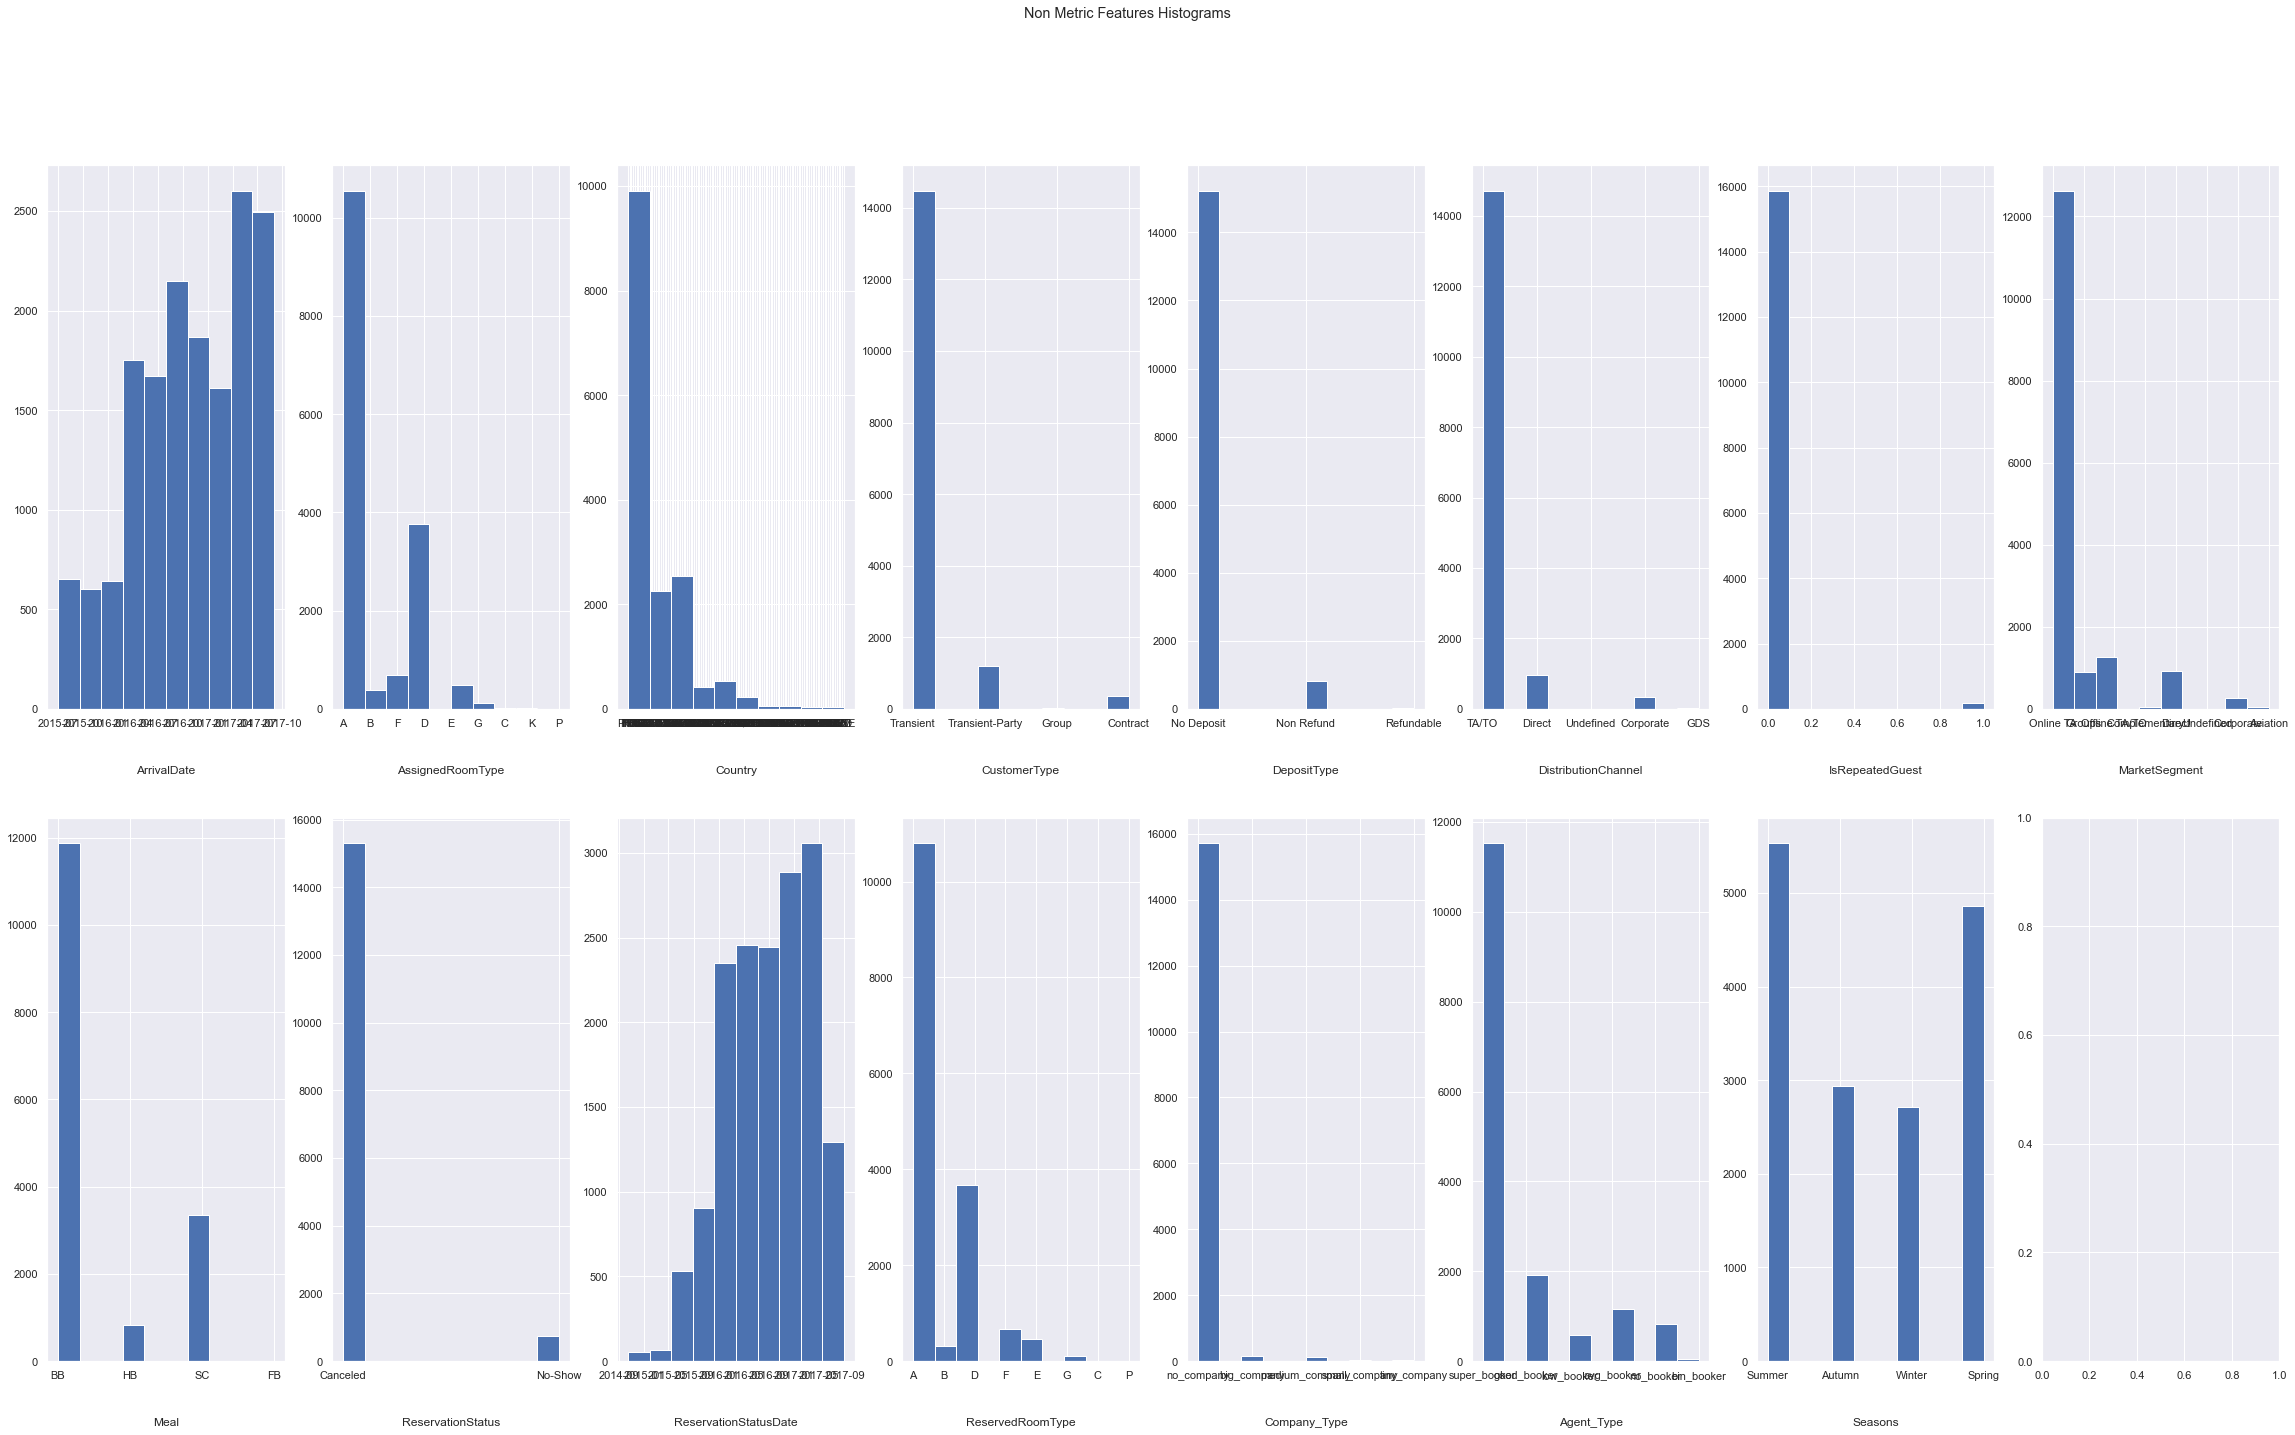

In [34]:
# Non Metric Features Histograms
sns.set()
fig, axes = plt.subplots(2, ceil(len(non_metric_features) / 2), figsize=(40, 22))

for ax, feat in zip(axes.flatten(), non_metric_features):
    ax.hist(df[feat][df['IsCanceled'] == 1])
    ax.set_title(feat, y=-0.13)
    
title = "Non Metric Features Histograms"

plt.suptitle(title)

plt.show()

In [35]:
#Separating the objetive function
y = df['IsCanceled']
df.drop(['IsCanceled'], axis = 1, inplace= True)

## Checking for Outliers in categorical features

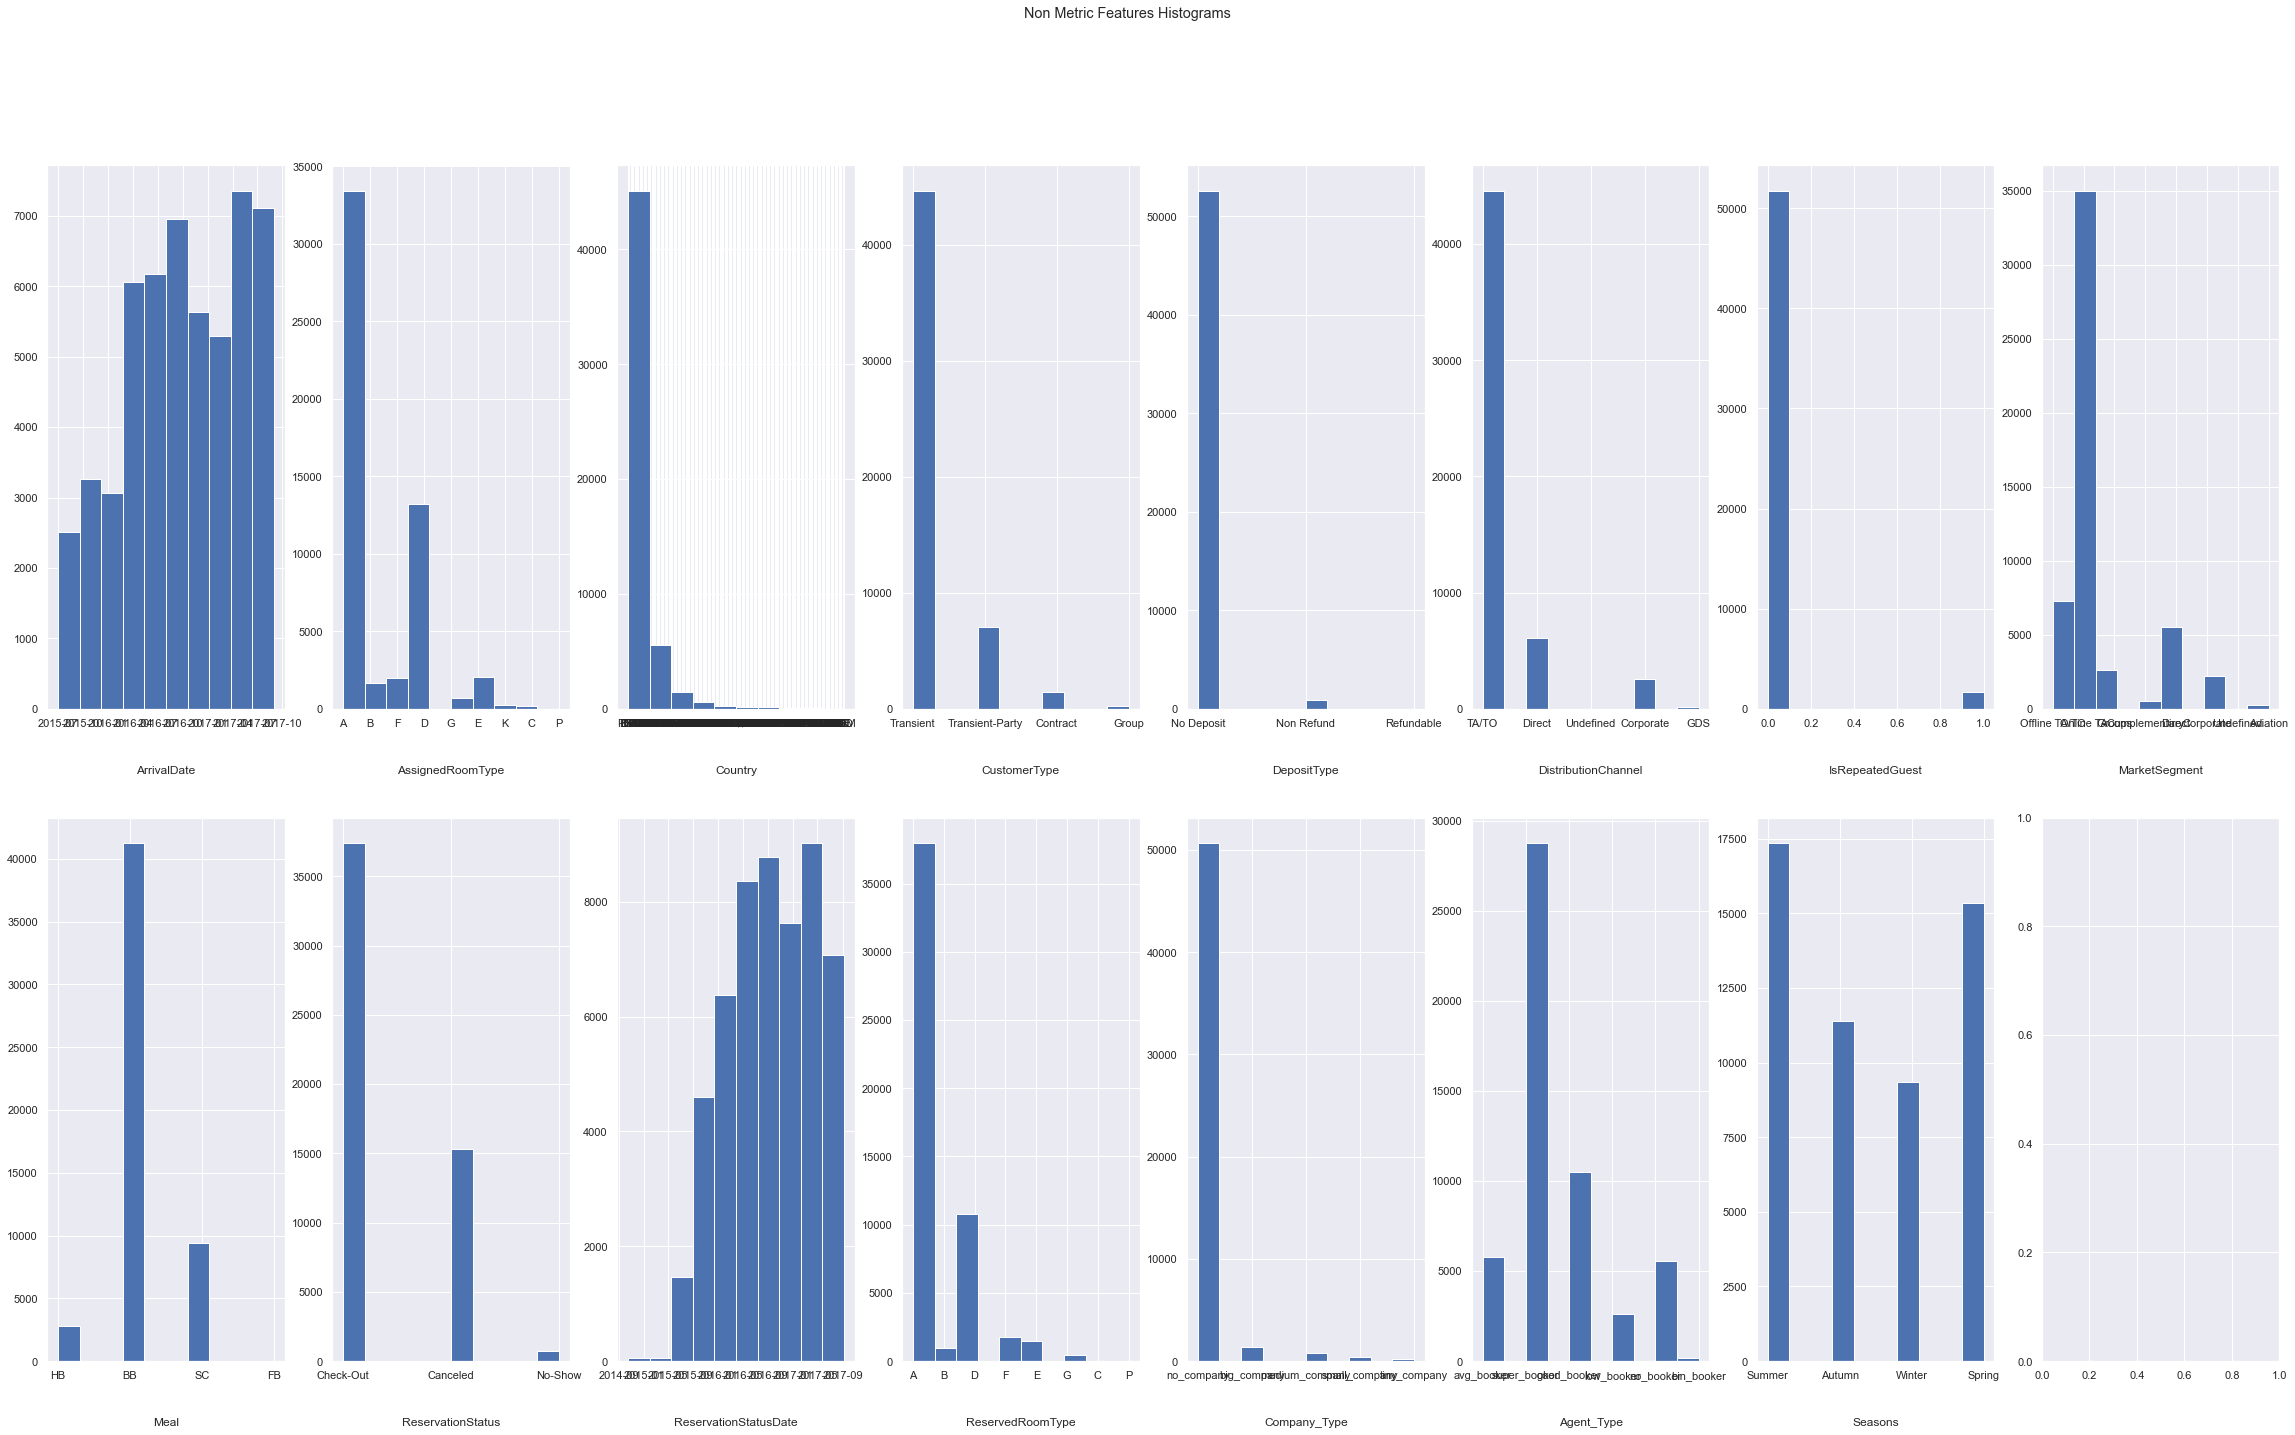

In [36]:
# Non Metric Features Histograms
sns.set()
fig, axes = plt.subplots(2, ceil(len(non_metric_features) / 2), figsize=(40, 22))

for ax, feat in zip(axes.flatten(), non_metric_features):
    ax.hist(df[feat])
    ax.set_title(feat, y=-0.13)
    
title = "Non Metric Features Histograms"

plt.suptitle(title)

plt.show()

#### Reservas só com crianças faz sentido?

In [37]:
index_out = df[(df['Adults'] == 0) & (df['Children'] == 0) ].index

df.drop(index = index_out, axis = 0, inplace = True)

y.drop(index = index_out, axis = 0, inplace = True)

## 151 outliers

In [38]:
index_out = df[df['Adults'] == 4].index

df.drop(index = index_out, axis = 0, inplace = True)

y.drop(index = index_out, axis = 0, inplace = True)

## 30 outliers

In [39]:
df['Babies'].unique()

array([ 0,  1, 10,  9,  2])

In [40]:
df[df['Babies']>=3]

,ADR,Adults,ArrivalDateWeekNumber,AssignedRoomType,Babies,BookingChanges,Children,Country,CustomerType,DaysInWaitingList,...,ReservationStatus,ReservationStatusDate,ReservedRoomType,StaysInWeekNights,StaysInWeekendNights,TotalOfSpecialRequests,ArrivalDate,Agent_Type,Company_Type,Seasons
6559,84.45,2,3,D,10,1,0.0,PRT,Transient,0,...,Check-Out,2016-01-14,D,2,0,1,2016-01-12,super_booker,no_company,Winter
38596,95.00,1,42,B,9,1,0.0,GBR,Transient-Party,0,...,Check-Out,2015-10-14,A,1,2,0,2015-10-11,low_booker,no_company,Autumn


Variavel com poucos casos diferentes de 0

In [41]:
df.drop('Babies', axis = 1, inplace = True)
metric_features.remove('Babies')

In [43]:
df['Meal'].unique()

array(['HB', 'BB', 'SC', 'FB'], dtype=object)

In [44]:
index_out = df[df['Meal'] == 'FB'].index

df.drop(index = index_out, axis = 0, inplace = True)

y.drop(index = index_out, axis = 0, inplace = True)

## 11 outliers

In [45]:
df['DepositType'].unique()

array(['No Deposit', 'Non Refund', 'Refundable'], dtype=object)

In [46]:
df[df['DepositType'] == 'Refundable'].shape

(15, 28)

In [47]:
df[(df['ReservationStatus'] == 'Canceled') & (df['ReservationStatusDate'] > df['ArrivalDate'])].shape

(0, 28)

In [48]:
df[(df['ReservationStatus'] == 'No-Show') & (df['ReservationStatusDate'] < df['ArrivalDate'])].shape

(0, 28)

## Checking for Outliers in numerical features

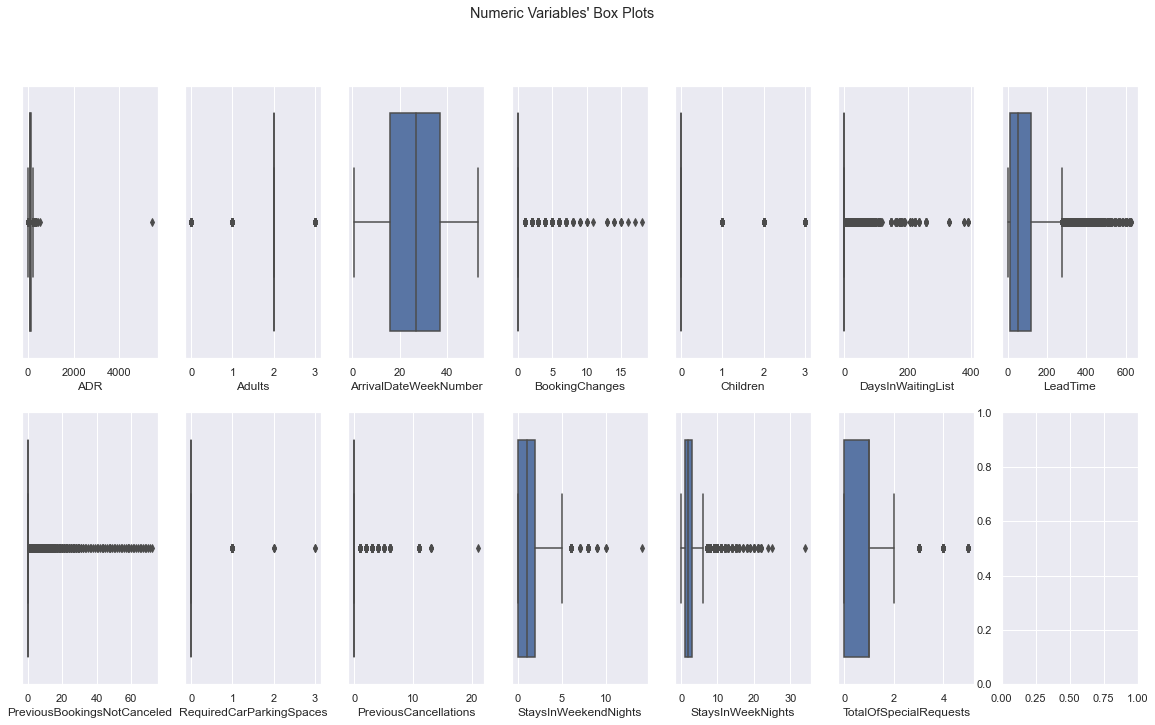

In [49]:
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot:
for ax, feat in zip(axes.flatten(), metric_features): 
    sns.boxplot(x=df[feat], ax=ax)

# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()

In [50]:
df[df['ADR'] > 4000]

,ADR,Adults,ArrivalDateWeekNumber,AssignedRoomType,BookingChanges,Children,Country,CustomerType,DaysInWaitingList,DepositType,...,ReservationStatus,ReservationStatusDate,ReservedRoomType,StaysInWeekNights,StaysInWeekendNights,TotalOfSpecialRequests,ArrivalDate,Agent_Type,Company_Type,Seasons
8455,5400.0,2,13,A,1,0.0,PRT,Transient,0,Non Refund,...,Canceled,2016-02-19,A,1,0,0,2016-03-25,avg_booker,no_company,Spring


In [51]:
index_out = df[df['ADR'] > 4000].index

df.drop(index = index_out, axis = 0, inplace = True)

y.drop(index = index_out, axis = 0, inplace = True)

## 1 outliers

In [52]:
df[df['PreviousCancellations'] >= 5].shape

(65, 28)

In [53]:
index_out = df[df['PreviousCancellations'] >= 5].index

df.drop(index = index_out, axis = 0, inplace = True)

y.drop(index = index_out, axis = 0, inplace = True)

## 65 outliers

In [54]:
df[df['DaysInWaitingList'] > 300].shape

(12, 28)

In [55]:
index_out = df[df['DaysInWaitingList'] > 300].index

df.drop(index = index_out, axis = 0, inplace = True)

y.drop(index = index_out, axis = 0, inplace = True)

## 12 outliers

In [56]:
df[df['BookingChanges'] > 12].shape

(12, 28)

In [57]:
index_out = df[df['BookingChanges'] > 12].index

df.drop(index = index_out, axis = 0, inplace = True)

y.drop(index = index_out, axis = 0, inplace = True)

## 12 outliers

In [58]:
# PERGUNTAR AO PROFESSOR OPINIAO
#df[df['PreviousBookingsNotCanceled'] > 60].shape

In [59]:
#index_out = df[df['PreviousBookingsNotCanceled'] > 60].index

#df.drop(index = index_out, axis = 0, inplace = True)

#y.drop(index = index_out, axis = 0, inplace = True)

## 12 outliers

In [60]:
df[df['StaysInWeekendNights'] > 8].shape

(7, 28)

In [61]:
index_out = df[df['StaysInWeekendNights'] > 8].index

df.drop(index = index_out, axis = 0, inplace = True)

y.drop(index = index_out, axis = 0, inplace = True)

## 7 outliers

In [62]:
df[df['StaysInWeekNights'] > 25].shape

(0, 28)

In [63]:
index_out = df[df['StaysInWeekNights'] > 25].index

df.drop(index = index_out, axis = 0, inplace = True)

y.drop(index = index_out, axis = 0, inplace = True)

## 1 outliers

In [64]:
df[df['TotalOfSpecialRequests'] > 4].shape

(22, 28)

In [65]:
index_out = df[df['TotalOfSpecialRequests'] > 4].index

df.drop(index = index_out, axis = 0, inplace = True)

y.drop(index = index_out, axis = 0, inplace = True)

## 22 outliers

### IQR Method 

In [66]:
# removing outliers in metric features using the iqr method 
def outliar_measure(data1, columns):
    data = data1.copy()
    for column in columns: 
        q1 = float(data[column].describe().iloc[4])
        q3 = float(data[column].describe().iloc[6])
        iqr = q3-q1    
        data = data[~((data[column] < (q1-1.5*iqr)) | (data[column] > (q3+1.5*iqr)))]        
    return data 





In [67]:
df[metric_features].shape

(53111, 13)

In [68]:
dfIQR = outliar_measure(df, metric_features)

In [69]:
dfIQR.shape

(25551, 28)

# Feature Engineering 

## One Hot Encoding for Categorical Variables 

In [70]:
df_ready = df.copy()

In [71]:
ohc_features = ['CustomerType',
 'DepositType',
 'DistributionChannel',
 'Meal',
 'ReservedRoomType',
 'Company_Type',
 'Agent_Type',
 'Seasons']

In [72]:
ohc = OneHotEncoder(sparse=False, drop = None)
ohc_feat_train = ohc.fit_transform(df_ready[ohc_features])
ohc_feat_names = ohc.get_feature_names()
df_ohc = pd.DataFrame(ohc_feat_train, index=df_ready.index,columns=ohc_feat_names)  # Why the index=df_ohc.index?

df_ohc.drop(['x0_Group','x1_Refundable', 'x2_Undefined', 'x3_HB',
            'x4_C','x5_tiny_company','x6_bin_booker','x7_Winter'],
            axis = 1, inplace= True)

## Scaling

In [73]:
df_scaled = df.copy()

In [74]:
# Applying Standard Scaler 
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(df_scaled[metric_features])
df_scaled[metric_features] = scaled_feat

### Merging Numerical Data with Categorical Data

In [75]:
df_scaled = pd.DataFrame(df_scaled, columns= metric_features, index = df.index).join(df_ohc)


## Feature Selection 

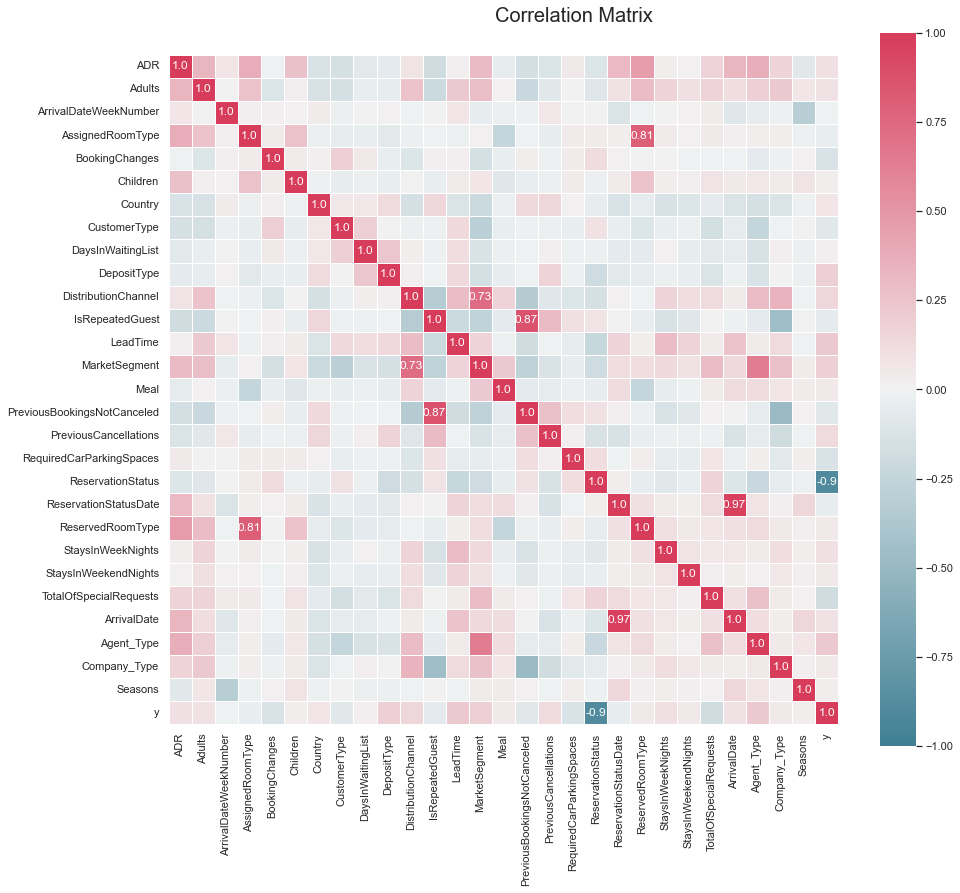

In [76]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df_le = df.copy()
df_le['y'] = y
le = LabelEncoder()


for col in non_metric_features:
    df_le[col] = le.fit_transform(df_le[col])

# Prepare figure
fig = plt.figure(figsize=(15, 12))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(df_le.corr(method="spearman"), decimals=2)

# Build annotation matrix (values above |0.7| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.7
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 5, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

plt.show()


Para ir de sopa: AssignedRoomtype, MarketSegment, IsRepeatedGuest, ReservationStatusDate, ReservationStatus

### Feature Selection for Categorical Data - Chi-Square Test


In [77]:
def TestIndependence(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

In [78]:
for var in df[non_metric_features]:
    TestIndependence(df[var], y, var)

ArrivalDate is IMPORTANT for Prediction
AssignedRoomType is IMPORTANT for Prediction
Country is IMPORTANT for Prediction
CustomerType is IMPORTANT for Prediction
DepositType is IMPORTANT for Prediction
DistributionChannel is IMPORTANT for Prediction
IsRepeatedGuest is IMPORTANT for Prediction
MarketSegment is IMPORTANT for Prediction
Meal is IMPORTANT for Prediction
ReservationStatus is IMPORTANT for Prediction
ReservationStatusDate is IMPORTANT for Prediction
ReservedRoomType is IMPORTANT for Prediction
Company_Type is IMPORTANT for Prediction
Agent_Type is IMPORTANT for Prediction
Seasons is IMPORTANT for Prediction


### Feature Selection for Numerical Data 


#### checking for univariate variables


In [79]:
df_scaled[metric_features].var()

ADR                            1.000019
Adults                         1.000019
ArrivalDateWeekNumber          1.000019
BookingChanges                 1.000019
Children                       1.000019
DaysInWaitingList              1.000019
LeadTime                       1.000019
PreviousBookingsNotCanceled    1.000019
RequiredCarParkingSpaces       1.000019
PreviousCancellations          1.000019
StaysInWeekendNights           1.000019
StaysInWeekNights              1.000019
TotalOfSpecialRequests         1.000019
dtype: float64

#### Lasso

Lasso picked 13 variables and eliminated the other 0 variables


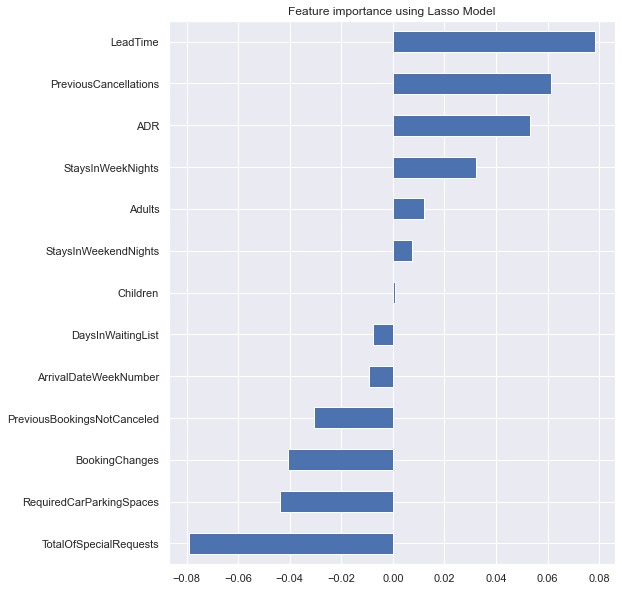

In [80]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

reg = LassoCV()

reg.fit(df_scaled[metric_features], y)

coef = pd.Series(reg.coef_, index = df_scaled[metric_features].columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

plot_importance(coef,'Lasso')

#### Decision Tree


In [81]:
gini_importance = DecisionTreeClassifier().fit(df_scaled[metric_features], y).feature_importances_
entropy_importance = DecisionTreeClassifier(criterion='entropy').fit(df_scaled[metric_features], y).feature_importances_

<AxesSubplot:xlabel='Value', ylabel='Col'>

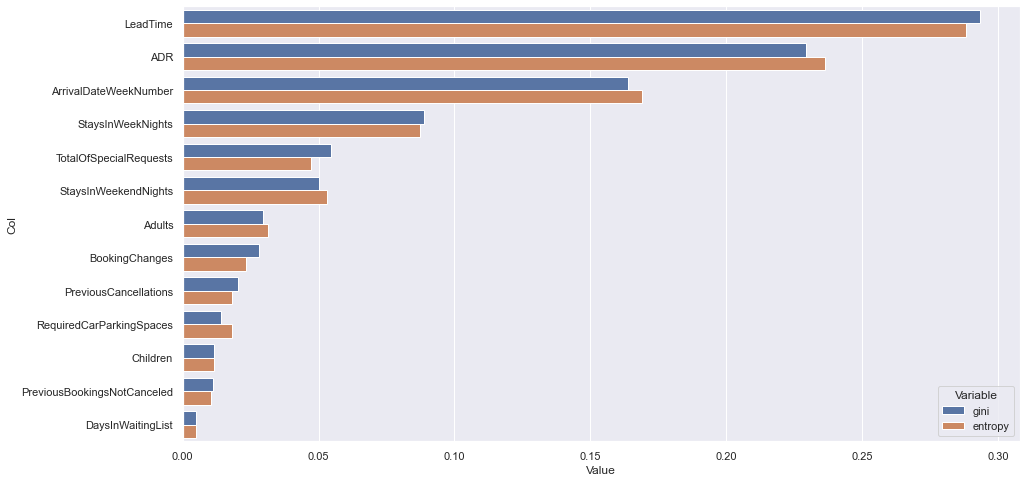

In [82]:
zippy = pd.DataFrame(zip(gini_importance, entropy_importance), columns = ['gini','entropy'])
zippy['col'] = df_scaled[metric_features].columns
tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize=(15,8))
sns.barplot(y='Col', x='Value', hue='Variable', data=tidy)

## Scalling Features

### Checking outliers using DBSCAN

In [84]:
y

0        0
1        1
2        1
3        1
4        1
        ..
79325    0
79326    0
79327    0
79328    0
79329    0
Name: IsCanceled, Length: 53111, dtype: int64

K-distance graph to find out the right eps value
neigh = NearestNeighbors(n_neighbors=24)
neigh.fit(df)
distances, _ = neigh.kneighbors(df)
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.show()

df.shape

Perform DBSCAN clustering
dbscan = DBSCAN(eps=1.25, min_samples=24, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df)

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

inserting in the datset with all the datas
df = pd.concat((df.reset_index(), pd.Series(dbscan_labels, name='dbscan_labels')), axis=1).set_index('CustID')

Concatenating the labels to df
St_DBSCAN = pd.concat([St_DBSCAN, pd.Series(dbscan_labels, index=St_DBSCAN.index, name="dbscan_client_labels")], axis=1)

# Exporting CSV ready for Models

In [85]:
df_to_models = pd.DataFrame(df_scaled[metric_features], columns= metric_features, index = df_scaled.index).join(df_ohc)

In [86]:
df_to_models.to_csv(r'../data/to_models.csv')

In [87]:
y.to_csv(r'../data/y.csv')